In [85]:
import random, csv, sys, itertools
import pandas as pd
import numpy as np
import re
import matplotlib
import matplotlib.pyplot as plt
import operator
import datetime
import sys
%matplotlib inline

# How does the pattern between killer/victim look between various incidents
# over the years. Is it mostly family/relation or do we see more reported gang
# violence for instance?

df = pd.read_csv('../data/clean_data_v1.csv', parse_dates=['date'])


In [136]:
mask = (df.date.dt.year >= 2014) & (df.date.dt.year <= 2018)
df = df.loc[mask]
df

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_age,participant_average_age,participant_age_group,participant_gender,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district
278,95289,2014-01-01,Michigan,Muskegon,300 block of Monroe Avenue,0,0,http://www.gunviolencearchive.org/incident/95289,http://www.mlive.com/news/muskegon/index.ssf/2...,False,...,0::Unknown,NaN,0::Adult 18+,0::Female,0::Unknown,0::Unharmed,0::Victim,http://www.mlive.com/news/muskegon/index.ssf/2...,92,34
279,92401,2014-01-01,New Jersey,Newark,Central Avenue,0,0,http://www.gunviolencearchive.org/incident/92401,http://www.nj.com/essex/index.ssf/2014/01/newa...,False,...,0::Unknown,NaN,0::Unknown,0::Unknown,0::Unknown,0::Unknown,0::Unknown,http://www.nj.com/essex/index.ssf/2014/01/newa...,29,29
280,92383,2014-01-01,New York,Queens,113th Avenue,1,0,http://www.gunviolencearchive.org/incident/92383,http://www.timesledger.com/stories/2014/2/firs...,False,...,0::22||1::26,24.00,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Unknown,0::Killed||1::Unharmed,0::Victim||1::Subject-Suspect,http://www.timesledger.com/stories/2014/2/firs...,33,14
281,92142,2014-01-01,New York,Brooklyn,St. Johns Place,0,1,http://www.gunviolencearchive.org/incident/92142,http://www.nydailynews.com/new-york/nyc-crime/...,False,...,0::34,34.00,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Unknown,0::Injured,0::Victim||1::Subject-Suspect,http://www.nydailynews.com/new-york/nyc-crime/...,43,20
282,95261,2014-01-01,Missouri,Springfield,Beverly Hills and Temple,0,1,http://www.gunviolencearchive.org/incident/95261,http://www.ozarksfirst.com/story/deputies-6-ye...,False,...,0::6||1::12,9.00,0::Child 0-11||1::Teen 12-17,0::Female,0::Unknown,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://www.ozarksfirst.com/story/deputies-6-ye...,131,30
283,92272,2014-01-01,Georgia,Columbus,1327 23rd Street,0,1,http://www.gunviolencearchive.org/incident/92272,http://www.ledger-enquirer.com/2014/08/25/3264...,False,...,0::27||1::25,26.00,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Unknown,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://www.ledger-enquirer.com/2014/01/02/2881...,135,15
284,92428,2014-01-01,New York,Syracuse,200 block of Ballard Avenue,0,1,http://www.gunviolencearchive.org/incident/92428,http://www.syracuse.com/news/index.ssf/2014/01...,False,...,0::20,20.00,0::Adult 18+,0::Male,0::Unknown,0::Injured,0::Victim,http://www.syracuse.com/news/index.ssf/2014/01...,128,53
285,94205,2014-01-01,Kentucky,Lexington,Kenton and Fourth streets,0,0,http://www.gunviolencearchive.org/incident/94205,http://www.lex18.com/news/police-searching-for...,False,...,0::Unknown,NaN,0::Unknown,0::Unknown,0::Unknown,0::Unknown,0::Unknown,http://www.lex18.com/news/police-searching-for...,0::Unknown,0::Unknown
286,92218,2014-01-01,Georgia,Bibb County,0::Unknown,0,1,http://www.gunviolencearchive.org/incident/92218,http://www.macon.com/2014/01/01/2858327/haddoc...,False,...,0::24||1::35,29.50,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Unknown,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://www.macon.com/2014/01/01/2858327/haddoc...,142,26
287,104905,2014-01-01,Virginia,Prince William County,10100 block of Shiloh Ct,0,1,http://www.gunviolencearchive.org/incident/104905,http://potomaclocal.com/2014/01/02/north-carol...,False,...,0::31||1::25,28.00,0::Adult 18+||1::Adult 18+,0::Male||1::Male,0::Unknown,0::Injured||1::Unharmed,0::Victim||1::Subject-Suspect,http://potomaclocal.com/2014/01/02/north-carol...,50,29


In [6]:
def csv_dict_to_py_dict(csv_string):
    if '::' in csv_string:
        py_dict = dict((key, value) for key, value in (item.split('::') for item in csv_string.split('||')))
    elif ':' in csv_string:
        py_dict = dict((key, value) for key, value in (item.split(':') for item in csv_string.split('|')))
    return py_dict


In [19]:
df["date"]=pd.to_datetime(df["date"],format="%Y-%m-%d")
df["Year"]=df["date"].apply(lambda time:time.year)
df["Month"]=df["date"].apply(lambda time:time.month)
df["Day"]=df["date"].apply(lambda time:time.day)
df["Day_of_Week"]=df["date"].apply(lambda time:time.dayofweek)
dmap = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}#We're Using this Dictionary to Map our column
df["Day_of_Week"]=df["Day_of_Week"].map(dmap)

df.head(2)

,incident_id,date,state,city_or_county,address,n_killed,n_injured,incident_url,source_url,incident_url_fields_missing,...,participant_relationship,participant_status,participant_type,sources,state_house_district,state_senate_district,Year,Month,Day,Day_of_Week
0,461105,2013-01-01,Pennsylvania,Mckeesport,1506 Versailles Avenue and Coursin Street,0,4,http://www.gunviolencearchive.org/incident/461105,http://www.post-gazette.com/local/south/2013/0...,False,...,0::Unknown,0::Arrested||1::Injured||2::Injured||3::Injure...,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://pittsburgh.cbslocal.com/2013/01/01/4-pe...,0::Unknown,0::Unknown,2013,1,1,Tue
1,460726,2013-01-01,California,Hawthorne,13500 block of Cerise Avenue,1,3,http://www.gunviolencearchive.org/incident/460726,http://www.dailybulletin.com/article/zz/201301...,False,...,0::Unknown,0::Killed||1::Injured||2::Injured||3::Injured,0::Victim||1::Victim||2::Victim||3::Victim||4:...,http://losangeles.cbslocal.com/2013/01/01/man-...,62,35,2013,1,1,Tue


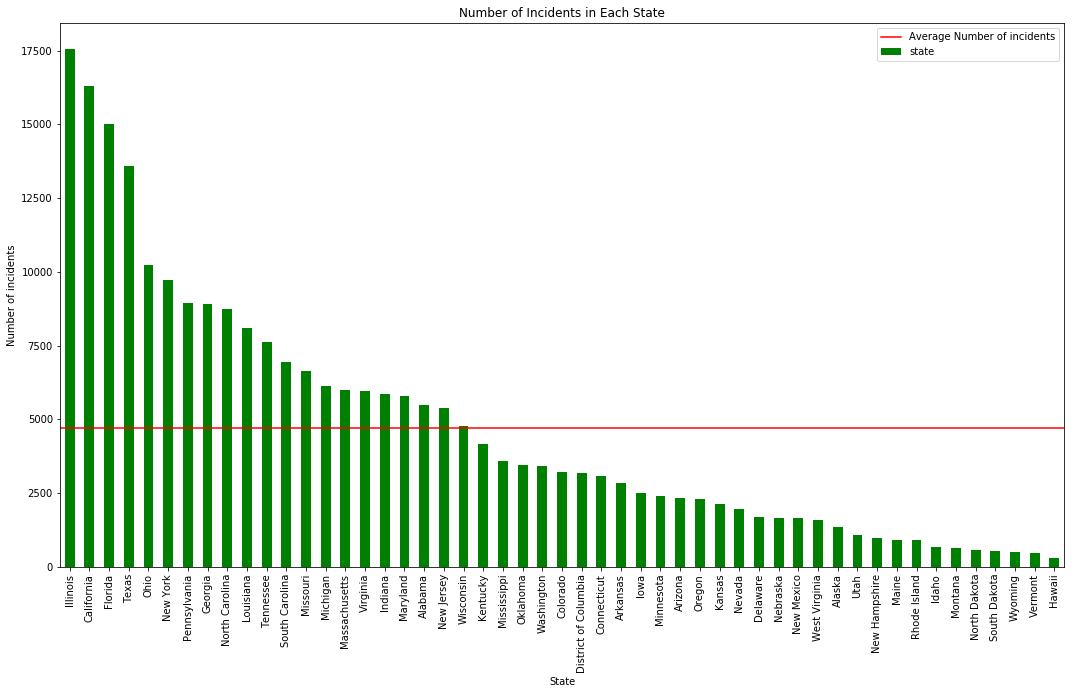

In [12]:
plot = df.state.value_counts().plot(kind='bar', \
                                     title="Number of Incidents in Each State", \
                                     figsize=(18,10), \
                                     colormap='ocean')
plot.set_xlabel('State')
plot.set_ylabel('Number of incidents')
mean_line = plot.axhline(df.state.value_counts().mean(), color='r',\
                         label='Average Number of incidents')
plt.legend()
plt.show()

In [15]:
def strip_first_class(descriptor):
    regex = re.compile('[a-zA-Z -]+')
    result = regex.findall(descriptor)
    return result[0]


In [138]:
df1 = df[['incident_id','date','participant_relationship']]

df1 = df1.loc[df1['participant_relationship'] != '0::Unknown']

x_axis_values = list(df1['participant_relationship'].unique())

x_axis_values = sorted(set([strip_first_class(value) for value in x_axis_values]))

results = {}

for value in df1['incident_id']:
    row = df1.loc[df1['incident_id'] == value]
    if 'Unknown' in str(row.participant_relationship.item()):
        continue
    else:
        year = int(row.date.dt.year)
        month = int(row.date.dt.month)
        rel = str(row.participant_relationship.item())
        rel = strip_first_class(rel)
        if year in results.keys():
            if month in results[year].keys():
                if rel in results[year][month].keys():
                    results[year][month][rel] += 1
                else:
                    results[year][month][rel] = 1
            else:
                results[year][month] = {}
                results[year][month][rel] = 1
        else:
            results[year] = {}
            results[year][month] = {}
            results[year][month][rel] = 1
    
    
results

{2014: {1: {'Aquaintance': 2,
   'Armed Robbery': 5,
   'Family': 21,
   'Friends': 4,
   'Home Invasion - Perp Does Not Know Victim': 2,
   'Home Invasion - Perp Knows Victim': 1,
   'Neighbor': 1,
   'Significant others - current or former': 7},
  2: {'Aquaintance': 3,
   'Armed Robbery': 4,
   'Family': 11,
   'Friends': 4,
   'Neighbor': 1,
   'Significant others - current or former': 7},
  3: {'Aquaintance': 2,
   'Armed Robbery': 7,
   'Family': 14,
   'Friends': 5,
   'Home Invasion - Perp Knows Victim': 1,
   'Neighbor': 1,
   'Significant others - current or former': 8},
  4: {'Aquaintance': 1,
   'Armed Robbery': 9,
   'Family': 12,
   'Gang vs Gang': 1,
   'Neighbor': 3,
   'Significant others - current or former': 8},
  5: {'Aquaintance': 1,
   'Armed Robbery': 6,
   'Family': 9,
   'Friends': 7,
   'Gang vs Gang': 3,
   'Home Invasion - Perp Knows Victim': 1,
   'Significant others - current or former': 9},
  6: {'Aquaintance': 1,
   'Armed Robbery': 7,
   'Family': 14,
  

In [139]:
#sort results dict so all relations are alphabetical
sorted_results = {}

for year, months in results.items():
    sorted_results[year] = {}
    for month, relations in months.items():
        sorted_results[year][month] = {}
        
        #sorted_relations = sorted(relations.keys(), key=lambda x:x.lower())
        
        for key in x_axis_values:
            if key in relations.keys():
                sorted_results[year][month][key] = relations[key]
            else:
                sorted_results[year][month][key] = 0

sorted_results

{2014: {1: {'Aquaintance': 2,
   'Armed Robbery': 5,
   'Co-worker': 0,
   'Drive by - Random victims': 0,
   'Family': 21,
   'Friends': 4,
   'Gang vs Gang': 0,
   'Home Invasion - Perp Does Not Know Victim': 2,
   'Home Invasion - Perp Knows Victim': 1,
   'Mass shooting - Perp Knows Victims': 0,
   'Mass shooting - Random victims': 0,
   'Neighbor': 1,
   'Significant others - current or former': 7},
  2: {'Aquaintance': 3,
   'Armed Robbery': 4,
   'Co-worker': 0,
   'Drive by - Random victims': 0,
   'Family': 11,
   'Friends': 4,
   'Gang vs Gang': 0,
   'Home Invasion - Perp Does Not Know Victim': 0,
   'Home Invasion - Perp Knows Victim': 0,
   'Mass shooting - Perp Knows Victims': 0,
   'Mass shooting - Random victims': 0,
   'Neighbor': 1,
   'Significant others - current or former': 7},
  3: {'Aquaintance': 2,
   'Armed Robbery': 7,
   'Co-worker': 0,
   'Drive by - Random victims': 0,
   'Family': 14,
   'Friends': 5,
   'Gang vs Gang': 0,
   'Home Invasion - Perp Does Not

In [150]:
# add all values per relation for each month, regardless of year
month_results = {}

for year, months in sorted_results.items():
    for month, relations in months.items():
        if month not in month_results.keys():
            month_results[month] = {}
        for relation, value in relations.items():
            if relation not in month_results[month].keys():
                month_results[month][relation] = value
            else:
                month_results[month][relation] += value


# only getting the relations we care about
print(x_axis_values)
selection = []
#selection.append(x_axis_values[0])
selection.append(x_axis_values[2])
selection.append(x_axis_values[4])
selection.append(x_axis_values[5])
selection.append(x_axis_values[6])
selection.append(x_axis_values[8])
selection.append(x_axis_values[11])
selection.append(x_axis_values[12])
print(selection)


#calculate total relations per month per year
total_relations = {}

for year, months in results.items():
    if year not in total_relations.keys():
        total_relations[year] = {}
    for month, relations in months.items():
        if month not in total_relations[year].keys():
            total_relations[year][month] = 0   
        for rel, value in relations.items():
            if rel in selection:
                total_relations[year][month] += value


['Aquaintance', 'Armed Robbery', 'Co-worker', 'Drive by - Random victims', 'Family', 'Friends', 'Gang vs Gang', 'Home Invasion - Perp Does Not Know Victim', 'Home Invasion - Perp Knows Victim', 'Mass shooting - Perp Knows Victims', 'Mass shooting - Random victims', 'Neighbor', 'Significant others - current or former']
['Co-worker', 'Family', 'Friends', 'Gang vs Gang', 'Home Invasion - Perp Knows Victim', 'Neighbor', 'Significant others - current or former']


36
36
36
36
36
36
36


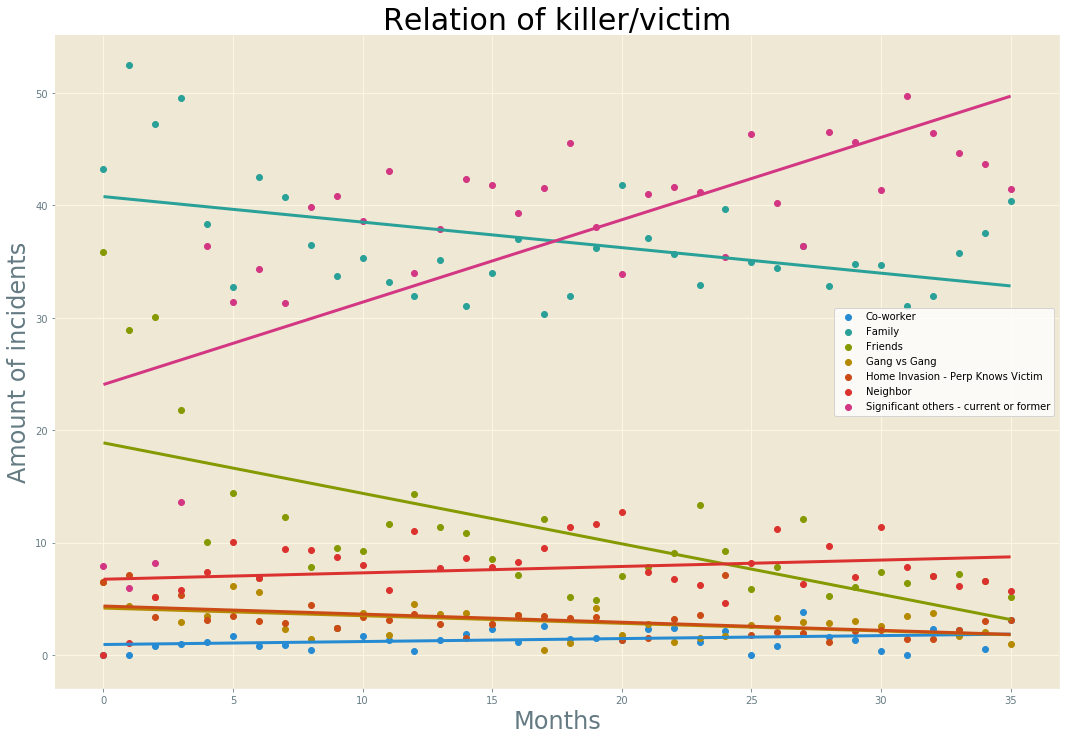

In [153]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split  

#Per year
# print(sorted_results)
plt.figure(figsize=(18,12))

with plt.style.context('Solarize_Light2'):
    for relation in selection:
        appended_values_per_rel = []
        appended_year_month = []
        for year in sorted(sorted_results)[1:]:
            months = sorted_results[year]
            months_total = total_relations[year]
            for month, relations in months.items():
#                 appended_year_month.append(str(month) + "-" + str(year))
                appended_values_per_rel.append(relations[relation]/months_total[month]*100)
        x = np.arange(36)
        print(len(appended_values_per_rel))
        plt.scatter(x, appended_values_per_rel, label=relation)
        x = x.reshape(-1, 1)
        regr = LinearRegression()  
        regr.fit(x, appended_values_per_rel) 
        y_pred = regr.predict(x)
        plt.plot(x, y_pred, linewidth=3)

#x_train, x_test, y_train, y_test = train_test_split(appended_year_month, appended_values_per_rel, test_size=0.2, random_state=0)  

plt.legend(loc='best')

plt.title('Relation of killer/victim', fontsize=30)
plt.xlabel('Months', fontsize=24)
plt.ylabel('Amount of incidents', fontsize=24)
plt.xticks(rotation=0)

plt.show()

In [27]:
# # per month
# plt.figure(figsize=(14,12))
# with plt.style.context('Solarize_Light2'):
#     for relation in selection:
#         relation_appended = []
#         for month, relations in month_results.items():
#             relation_appended.append(relations[relation])
        
#         plt.plot(month_results.keys(), relation_appended, label=relation)

# plt.xticks(rotation=0)
# plt.legend(loc='best')

# plt.yticks(np.arange(0,350,20))
# plt.xticks(np.arange(0,13,1))

# plt.title('Relation of killer/victim', fontsize=30)
# plt.xlabel('Months', fontsize=24)
# plt.ylabel('Amount of incidents', fontsize=24)
# plt.show()

In [13]:
# Per year
#plt.figure(figsize=(40,60))
#with plt.style.context('Solarize_Light2'):
#    for year in sorted_results.values():
#        for relation in selection:
#            relation_appended = []
#            for month, relations in year.items():
#                relation_appended.append(relations[relation])
#            
#            plt.plot(year.keys(), relation_appended, label=relation)
#            plt.xticks(rotation=0)


#plt.legend(loc='best')

#plt.title('Relation of killer/victim', fontsize=30)
#plt.xlabel('Months', fontsize=24)
#plt.ylabel('Amount of incidents', fontsize=24)
#plt.show()